In [12]:
import jax
import jax.numpy as jnp
import jax.random as jxr
from jax import jit, grad, vmap
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from models import WeightSpaceGaussianProcess, wGPLDS
import utils


In [13]:
# Define model
_sigma, _kappa, _period = 0.2, 0.2, 2*jnp.pi
torus_basis_funcs = utils.torus_basis(3, _sigma, _kappa, _period)

def weight_space_coefficients(m):
    return _sigma * jnp.sqrt(jnp.exp(- 2* jnp.pi**2 * _kappa**2 * m**2))

latent_dim = 2
obs_dim = 3
A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=obs_dim, D2=latent_dim)
b_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=obs_dim, D2=1)

In [14]:
def diag_penalty(N):
    coeffs = []
    for n in jnp.arange(-N, N):
        coeff = weight_space_coefficients(n)
        coeffs.append(coeff)
        coeffs.append(coeff) # twice
    return jnp.array(coeffs)

diag_penalty(3)

Array([0.00572739, 0.00572739, 0.0412306 , 0.0412306 , 0.13476509,
       0.13476509, 0.2       , 0.2       , 0.13476509, 0.13476509,
       0.0412306 , 0.0412306 ], dtype=float32)

In [15]:
# def run_dynamics(key, As, bs, m0, S0):
#     def f(x, inp):
#         A, b, (subkey1, subkey2) = inp
        
#         dynamics_noise = noise_scale * (
#             jxr.multivariate_normal(subkey1, jnp.zeros(latent_dim), jnp.eye(latent_dim))
#         )
#         x_next = A @ x + b + dynamics_noise
#         return x_next, (x_next)

#     x_init = jxr.multivariate_normal(key, m0, S0)
#     subkeys = jxr.split(key, num=(As.shape[0],2))
#     _, x_nexts = jax.lax.scan(f, x_init, xs=(As, bs, subkeys))
#     xs = jnp.concatenate([x_init[None, :], x_nexts[:-1]], axis=0)
#     return xs

def func(key, As, bs, xs):
    T, D2, D1 = As.shape
    def f(A, b, x, _key):
        noise = noise_scale * jxr.normal(_key, (D2,))
        return A @ x + b + noise
    subkeys = jxr.split(key, num=(As.shape[0],))
    ys = vmap(f)(As, bs, xs, subkeys)
    return ys

# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
theta = jnp.cumsum(omega)

m0 = jnp.zeros(latent_dim)
S0 = jnp.eye(latent_dim)
noise_scale = 0.05
true_key = jxr.PRNGKey(44)
key1, key2 = jxr.split(true_key)
As = A_prior.sample(key1, theta)
bs = b_prior.sample(key2, theta).squeeze()
# bs = jnp.zeros((num_timesteps, latent_dim))

(100, 100, 3)


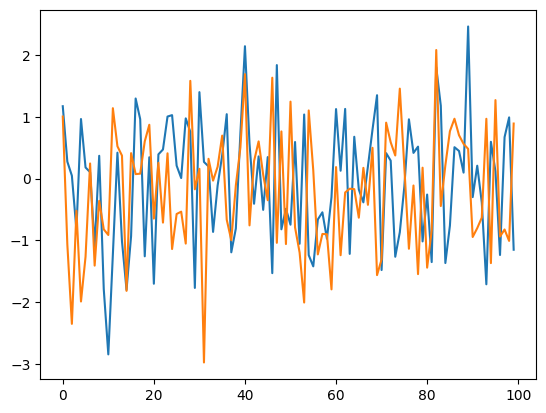

In [16]:
# Generate Xs
key = jxr.PRNGKey(0)
B = 100
X = jxr.normal(key, (B, num_timesteps, latent_dim))
Y = jax.vmap(lambda _key, _xs: func(_key, As, bs, _xs), in_axes=(0,0))(jxr.split(key, num=100), X)

print(Y.shape)
plt.plot(X[0,:,0])
plt.plot(X[0,:,1])

(100, 2, 12)


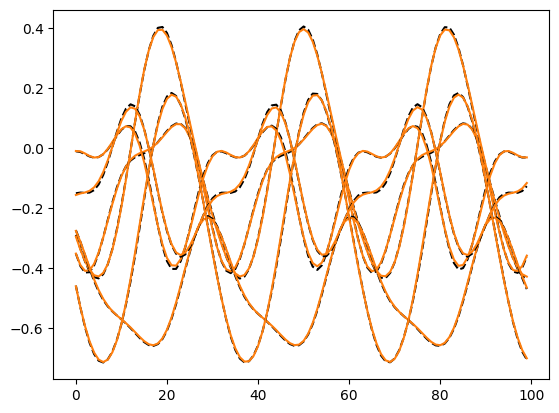

In [24]:
# Do the weight-space lin reg for A

conditions = theta#[:-1]
Ex = X.mean(0)
Exp = Ex[:-1]
Exn = Ex[1:]

len_basis = len(A_prior.basis_funcs)    
D1 = A_prior.D1
D2 = A_prior.D2

PhiAp = A_prior.evaluate_basis(conditions) # shape T x K
def e_step(xs, ys):
    _Y = ys - bs#[:,None] # shape T x D1

    Z = jnp.einsum('tk,ti->tik', PhiAp, xs)#.reshape(-1, len_basis * D2)
    print(Z.shape)
    # Z = jax.vmap(lambda _phi, _ex: jnp.outer(_phi, _ex))(PhiAp, Exp)
    ZTZ = jnp.einsum('tik,tjl->ikjl', Z, Z).reshape(len_basis * D2, len_basis * D2)
    # ZTZ = Z.T @ Z
    ZTY = jnp.einsum('tik,tj->ikj', Z, _Y).reshape(len_basis * D2, D1)
    # ZTY = Z.T @ _Y
    stats = (ZTZ, ZTY)
    return stats

def m_step(stats):
    ZTZ, ZTY = stats
    w_MAP = jax.scipy.linalg.solve(ZTZ + jnp.eye(len_basis * D2), ZTY, assume_a='pos')
    w_MAP = w_MAP.reshape(D2, len_basis, D1).transpose(1,2,0)
    return w_MAP

# Fitting
batch_stats = vmap(e_step)(X, Y)
stats = jax.tree_util.tree_map(lambda x: jnp.sum(x, axis=0), batch_stats)
w_MAP = m_step(stats)

A_recovered = A_prior(w_MAP, conditions)

plt.figure()
for i in range(A_prior.D1):
    for j in range(A_prior.D2):
        plt.plot(As[:,i,j], 'k--')
        plt.plot(A_recovered[:,i,j], c='tab:orange')

# plt.plot([jnp.linalg.det(F).itzem() for F in As])
# plt.plot([jnp.linalg.det(F).item() for F in A_recovered])

In [7]:
As.shape

(100, 3, 2)

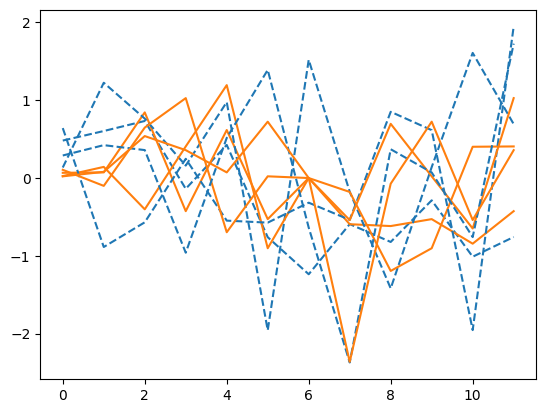

In [8]:
for i in range(latent_dim):
    for j in range(latent_dim):
        plt.plot(A_prior.weights(key1)[:,i,j], c='tab:blue', ls='--')
        plt.plot(w_MAP[:,i,j], c='tab:orange')

In [9]:
# x_map = model.smoother(true_params, Y[i]).smoothed_means.squeeze()
# fs = x_map[1:]
# xs = jnp.multiply(evaluate_basis(A_prior.basis_funcs, theta[:-1]), x_map[:-1]).T

# Ex = X.mean(0)

def construct_XY(xs, conditions, A_prior):
    _X = jnp.multiply(A_prior.evaluate_basis(conditions), xs[:-1]) + bs[:-1][:,None]
    _Y = xs[1:]
    return _X, _Y

_X, _Y = jax.vmap(lambda x: construct_XY(x, theta[:-1], A_prior))(X)
_X = jnp.concatenate(_X, axis=0)
_Y = jnp.concatenate(_Y, axis=0)
_w_map = jax.scipy.linalg.solve(_X.T @ _X + jnp.eye(len_basis), _X.T @ _Y)
_w_map = _w_map.reshape(len_basis, D1, D1)

plt.plot(A_prior(_w_map, theta[:-1]).squeeze())
plt.plot(As.squeeze())

TypeError: mul got incompatible shapes for broadcasting: (99, 12), (99, 2).

(100, 3, 1)


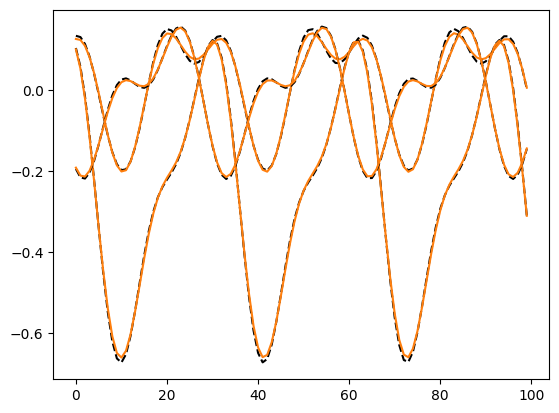

In [11]:
# Do the weight-space lin reg for A

conditions = theta#[:-1]
Ex = X.mean(0)
Exp = Ex[:-1]
Exn = Ex[1:]

len_basis = len(b_prior.basis_funcs)    
D1 = b_prior.D1
D2 = b_prior.D2

Phib = b_prior.evaluate_basis(conditions) # shape T x K
def b_e_step(xs, ys):
    _Y = ys - jax.vmap(lambda A, x: A @ x)(As, xs) # shape T x D1
    Z = Phib.reshape(len(_Y), D2, len_basis)
    # Z = jax.vmap(lambda _phi, _ex: jnp.outer(_phi, _ex))(PhiAp, Exp)
    ZTZ = jnp.einsum('tki,tlj->kilj', Z, Z).reshape(len_basis * D2, len_basis * D2)
    # ZTZ = Z.T @ Z
    ZTY = jnp.einsum('tki,tj->kij', Z, _Y).reshape(len_basis * D2, D1)
    # ZTY = Z.T @ _Y
    stats = (ZTZ, ZTY)
    return stats

def b_m_step(stats):
    ZTZ, ZTY = stats
    w_MAP = jax.scipy.linalg.solve(ZTZ + jnp.eye(len_basis * D2), ZTY, assume_a='pos')
    w_MAP = w_MAP.reshape(D2, len_basis, D1).transpose(1,2,0)
    return w_MAP

# Fitting
batch_stats = vmap(b_e_step)(X, Y)
stats = jax.tree_util.tree_map(lambda x: jnp.sum(x, axis=0), batch_stats)
w_MAP = b_m_step(stats)

b_recovered = b_prior(w_MAP, conditions)

plt.figure()
for i in range(b_prior.D1):
    for j in range(b_prior.D2):
        plt.plot(bs[:,i], 'k--')
        plt.plot(b_recovered[:,i], c='tab:orange')

# plt.plot([jnp.linalg.det(F).itzem() for F in As])
# plt.plot([jnp.linalg.det(F).item() for F in A_recovered])

In [26]:
jnp.outer(jnp.ones((10,3)), jnp.ones((10,3)), axis=1).shape

TypeError: outer() got an unexpected keyword argument 'axis'

# Matrix reg

In [49]:
def func(key, As, Xs):
    T, D1, D2 = As.shape
    def f(A, X, _key):
        noise = noise_scale * jxr.normal(_key, (D1, D2,))
        return A @ X + noise
    subkeys = jxr.split(key, num=(As.shape[0],))
    Ys = vmap(f)(As, Xs, subkeys)
    return Ys

# Sample heading direction with constant velocity
num_timesteps = 100
speed = 0.2
omega = jnp.ones(num_timesteps) * speed
theta = jnp.cumsum(omega)

true_key = jxr.PRNGKey(44)
A_prior = WeightSpaceGaussianProcess(torus_basis_funcs, D1=obs_dim, D2=latent_dim)
As = A_prior.sample(true_key, theta)

# Generate data
def generate_batch(key):
    key1, key2 = jxr.split(key)
    Xs = jxr.normal(key1, (num_timesteps, latent_dim, latent_dim))
    Ys = func(key2, As, Xs)
    return Xs, Ys

B = 50
X, Y = jax.vmap(generate_batch)(jxr.split(jxr.PRNGKey(0), num=B))
print(X.shape)

(50, 100, 2, 2)


(100, 2, 2) (100, 3, 2)


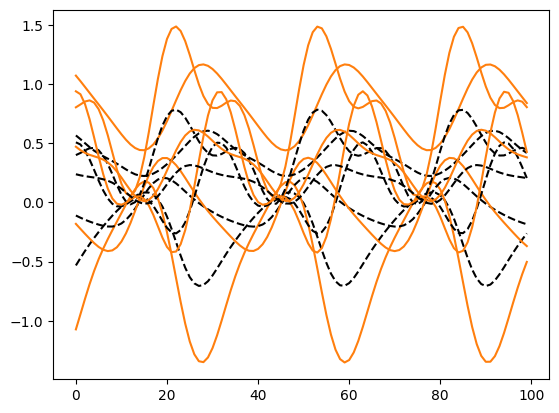

In [57]:
# Do the weight-space lin reg for A

conditions = theta
PhiA = A_prior.evaluate_basis(conditions) # shape T x K

len_basis = len(A_prior.basis_funcs)
D1 = A_prior.D1
D2 = A_prior.D2

def e_step(Xs, Ys):
    # # With A X^T Y + A^T X^T X A form, all _t indexed
    # Z = jnp.einsum('tk,tij->tijk', PhiA, Xs) # Each X is a matrix of shape D1 x D2
    # ZTZ = jnp.einsum('timk,tjml->ikjl', Z, Z).reshape(len_basis * D2, len_basis * D2)
    # ZTY = jnp.einsum('timk,tjm->ikj', Z, Ys).reshape(len_basis * D2, D1)

    # With A U + A V A form
    print(Xs.shape, Ys.shape)
    U = jnp.einsum('tmi,tjm->tij', Xs, Ys) # will be given
    V = jnp.einsum('tim,tmj->tij', Xs, Xs) # will be given
    ZTY = jnp.einsum('tk,tij->ikj', PhiA, U).reshape(len_basis * D2, D1)
    AV = jnp.einsum('tk,tij->tijk', PhiA, V)
    ZTZ = jnp.einsum('tijk,tl->ikjl', AV, PhiA).reshape(len_basis * D2, len_basis * D2)
    stats = (ZTZ, ZTY)
    return stats

def m_step(stats):
    ZTZ, ZTY = stats
    w_MAP = jax.scipy.linalg.solve(ZTZ + jnp.eye(len_basis * D2), ZTY)
    w_MAP = w_MAP.reshape(D2, len_basis, D1).transpose(1,2,0)
    return w_MAP

# Fitting
batch_stats = vmap(e_step)(X, Y)
stats = jax.tree_util.tree_map(lambda x: jnp.sum(x, axis=0), batch_stats)
w_MAP = m_step(stats)

A_recovered = A_prior(w_MAP, conditions)

plt.figure()
for i in range(A_prior.D1):
    for j in range(A_prior.D2):
        plt.plot(As[:,i,j], 'k--')
        plt.plot(A_recovered[:,i,j], c='tab:orange')

# plt.plot([jnp.linalg.det(F).itzem() for F in As])
# plt.plot([jnp.linalg.det(F).item() for F in A_recovered])